# ETL Y EDA INVENTARIO INICIAL 2016

In [2]:
#LIBRERIAS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [3]:
#Cargamos el archivo y nombramos dataset
inv_inicial = pd.read_csv ("BegInvFINAL12312016.csv")

In [4]:
#Informacion el dataset
inv_inicial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206529 entries, 0 to 206528
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InventoryId  206529 non-null  object 
 1   Store        206529 non-null  int64  
 2   City         206529 non-null  object 
 3   Brand        206529 non-null  int64  
 4   Description  206529 non-null  object 
 5   Size         206529 non-null  object 
 6   onHand       206529 non-null  int64  
 7   Price        206529 non-null  float64
 8   startDate    206529 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 14.2+ MB


In [5]:
#Primeras filas
inv_inicial.head()

,InventoryId,Store,City,Brand,Description,Size,onHand,Price,startDate
0,1_HARDERSFIELD_58,1,HARDERSFIELD,58,Gekkeikan Black & Gold Sake,750mL,8,12.99,2016-01-01
1,1_HARDERSFIELD_60,1,HARDERSFIELD,60,Canadian Club 1858 VAP,750mL,7,10.99,2016-01-01
2,1_HARDERSFIELD_62,1,HARDERSFIELD,62,Herradura Silver Tequila,750mL,6,36.99,2016-01-01
3,1_HARDERSFIELD_63,1,HARDERSFIELD,63,Herradura Reposado Tequila,750mL,3,38.99,2016-01-01
4,1_HARDERSFIELD_72,1,HARDERSFIELD,72,No. 3 London Dry Gin,750mL,6,34.99,2016-01-01


In [6]:
#Estadisticas de cada columna
for i in inv_inicial.columns:
    print(i)
    #Esto imprime las estadísticas descriptivas (como count, mean, std, min, 25%, 50%, 75%, max) para esa columna.
    print(inv_inicial[i].describe())
    print('--------------------------------------------------------------')

InventoryId
count                 206529
unique                206529
top       79_BALLYMENA_90089
freq                       1
Name: InventoryId, dtype: object
--------------------------------------------------------------
Store
count    206529.000000
mean         42.122457
std          23.191393
min           1.000000
25%          22.000000
50%          42.000000
75%          64.000000
max          79.000000
Name: Store, dtype: float64
--------------------------------------------------------------
City
count        206529
unique           67
top       MOUNTMEND
freq          14264
Name: City, dtype: object
--------------------------------------------------------------
Brand
count    206529.000000
mean      13761.482320
std       13059.429355
min          58.000000
25%        3746.000000
50%        8010.000000
75%       22143.000000
max       90090.000000
Name: Brand, dtype: float64
--------------------------------------------------------------
Description
count                   2065

In [7]:
# Convertimos la columna 'startDate' a tipo de dato datetime, usando el paramero errors="coerce"
inv_inicial['startDate'] = pd.to_datetime(inv_inicial['startDate'], errors='coerce')
print (inv_inicial['startDate'].dtypes)


datetime64[ns]


In [8]:
#Exploración de Valores Anómalos
#onHand y Price verificar que estas columnas no tengan valores negativos, 
# ya que onHand debería ser positivo (o cero) y Price generalmente también.

inv_inicial = inv_inicial[inv_inicial['onHand'] >= 0]
inv_inicial = inv_inicial[inv_inicial['Price'] >= 0]

In [9]:
#Convirtiendo y creando una nueva columna para Size. quedando Size_ml
import re

def convertir_a_ml(size):
    # Expresión regular para extraer el número principal, unidad y posibles cantidades de paquetes
    match = re.match(r"(\d+(\.\d+)?)\s*(mL|L|liter|oz)?(?:\s*(\d+)?\s*Pk)?", str(size), re.IGNORECASE)
    
    if match:
        valor = float(match.group(1))  # Valor numérico principal
        unidad = match.group(3).lower() if match.group(3) else ''  # Unidad de medida
        cantidad_pk = int(match.group(4)) if match.group(4) else 1  # Cantidad en el paquete, por defecto 1
        
        # Convertir a mililitros según la unidad
        if unidad in ['l', 'liter']:
            return valor * 1000 * cantidad_pk  # Convertir litros a mililitros y multiplicar por cantidad
        elif unidad == 'oz':
            return valor * 29.5735 * cantidad_pk  # Convertir onzas a mililitros y multiplicar por cantidad
        elif unidad == 'ml':
            return valor * cantidad_pk  # Ya está en mililitros, multiplicar por cantidad
    return None

# Aplicar la función a la columna 'Size' para crear la columna 'Size_ml' en mL
inv_inicial['Size_ml'] = inv_inicial['Size'].apply(convertir_a_ml)

# Verificar el resultado
print(inv_inicial[['Size', 'Size_ml']].head(10))


    Size  Size_ml
0  750mL    750.0
1  750mL    750.0
2  750mL    750.0
3  750mL    750.0
4  750mL    750.0
5  750mL    750.0
6  750mL    750.0
7  750mL    750.0
8  Liter      NaN
9  750mL    750.0


In [10]:
# Eliminar filas donde 'Size_ml' tiene valores NaN
inv_inicial = inv_inicial.dropna(subset=['Size_ml'])

# Verificar el resultado
print(inv_inicial['Size_ml'].unique())


[  750.      1750.        50.       375.       200.      2250.
  1125.       600.       150.       400.       100.       250.
   800.      1000.      1500.      5000.      4000.       748.
  3000.       147.8675   187.       500.       561.       300.
   330.     18000.       180.       720.       650.617   6000.
 20000.    ]


In [11]:
#Borramos la columna Size

del inv_inicial['Size']

In [12]:
inv_inicial.columns

Index(['InventoryId', 'Store', 'City', 'Brand', 'Description', 'onHand',
       'Price', 'startDate', 'Size_ml'],
      dtype='object')

#### GRAFICOS PARA ANALISIS POR COLUMNAS

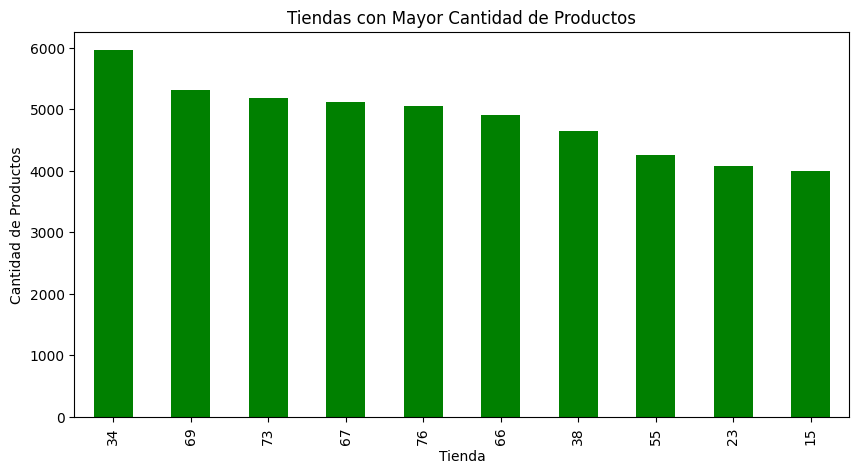

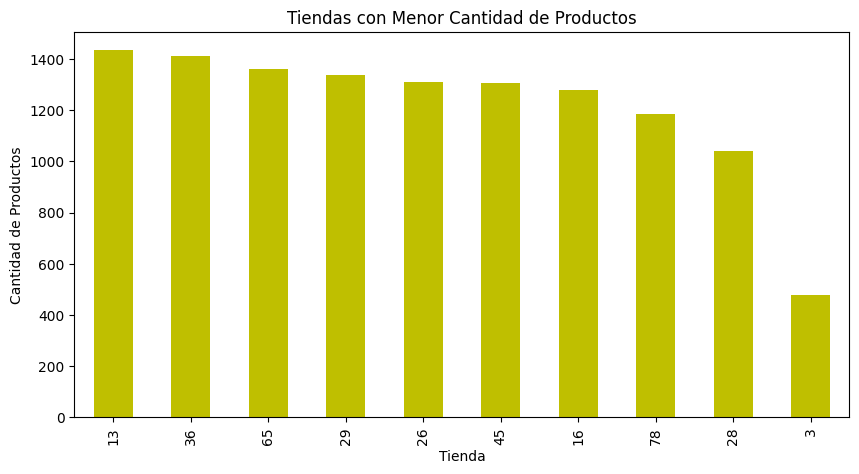

In [13]:
#Relacion tiendas y productos
# Top 10 tiendas con mayor cantidad de productos
max_10 = inv_inicial['Store'].value_counts().head(10)

# Top 10 tiendas con menor cantidad de productos
menor_10 = inv_inicial['Store'].value_counts().tail(10)

# Gráfico para tiendas con mayor cantidad de productos
plt.figure(figsize=(10, 5))
max_10.plot(kind='bar', color='green')
plt.title('Tiendas con Mayor Cantidad de Productos')
plt.xlabel('Tienda')
plt.ylabel('Cantidad de Productos')
plt.show()

# Gráfico para tiendas con menor cantidad de productos
plt.figure(figsize=(10, 5))
menor_10.plot(kind='bar', color='y')
plt.title('Tiendas con Menor Cantidad de Productos')
plt.xlabel('Tienda')
plt.ylabel('Cantidad de Productos')
plt.show()


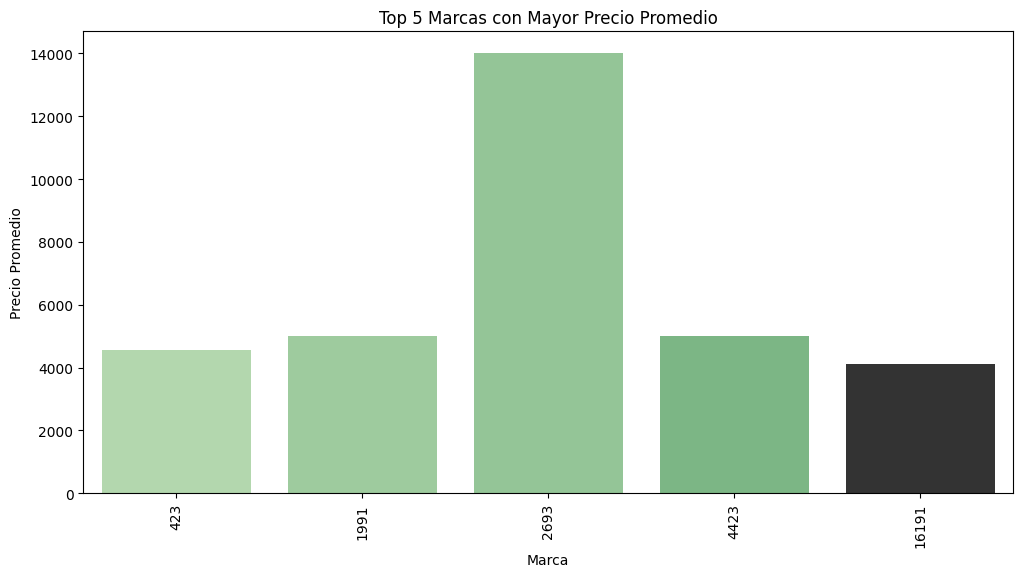

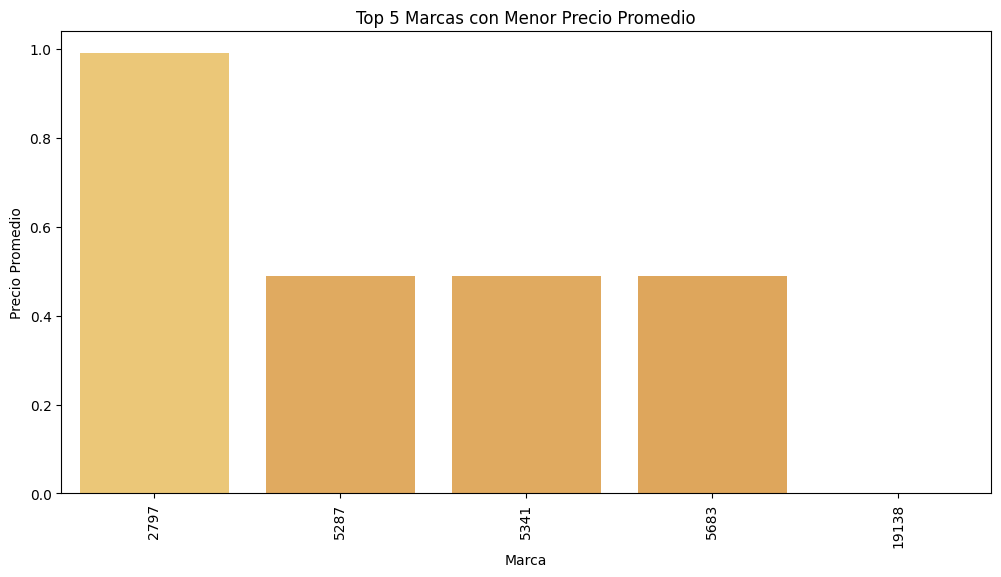

In [14]:
#Graficos para Price y Brand
# Calcular precio promedio por marca
price_brand = inv_inicial.groupby('Brand')['Price'].mean()

# Top 5 marcas con mayor precio promedio
max_p_b = price_brand.sort_values(ascending=False).head(5)

# Top 5 marcas con menor precio promedio
min_p_b = price_brand.sort_values(ascending=True).head(5)

# Gráfico para marcas con mayor precio promedio
plt.figure(figsize=(12, 6))
sns.barplot(x=max_p_b.index, y=max_p_b.values, hue=max_p_b.index, dodge=False, palette='Greens_d')
plt.title('Top 5 Marcas con Mayor Precio Promedio')
plt.xlabel('Marca')
plt.ylabel('Precio Promedio')
plt.xticks(rotation=90)
plt.legend([], [], frameon=False)  # Remueve la leyenda innecesaria
plt.show()

# Gráfico para marcas con menor precio promedio
plt.figure(figsize=(12, 6))
sns.barplot(x=min_p_b.index, y=min_p_b.values, hue=min_p_b.index, dodge=False, palette='YlOrBr_d')
plt.title('Top 5 Marcas con Menor Precio Promedio')
plt.xlabel('Marca')
plt.ylabel('Precio Promedio')
plt.xticks(rotation=90)
plt.legend([], [], frameon=False)
plt.show()


#### Cantidad de Productos en Stock (onHand) por Ciudad (City)

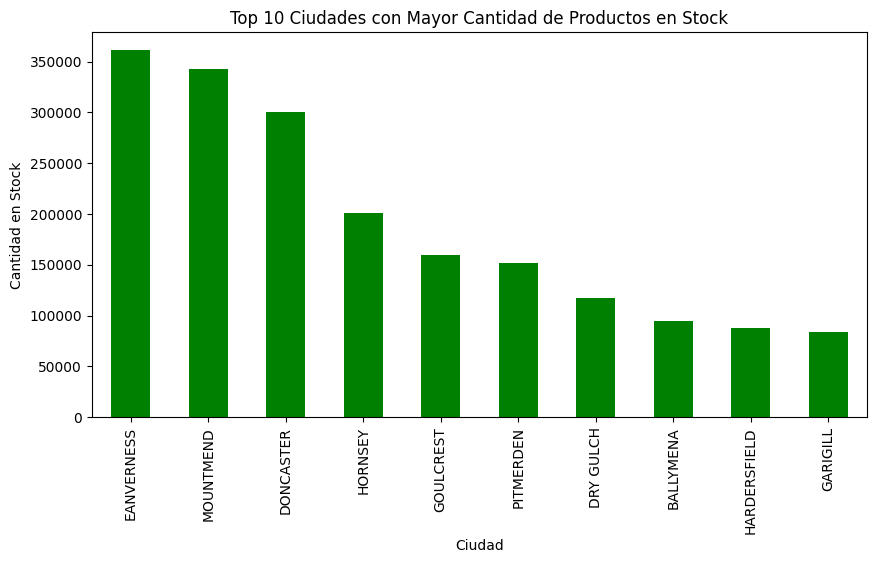

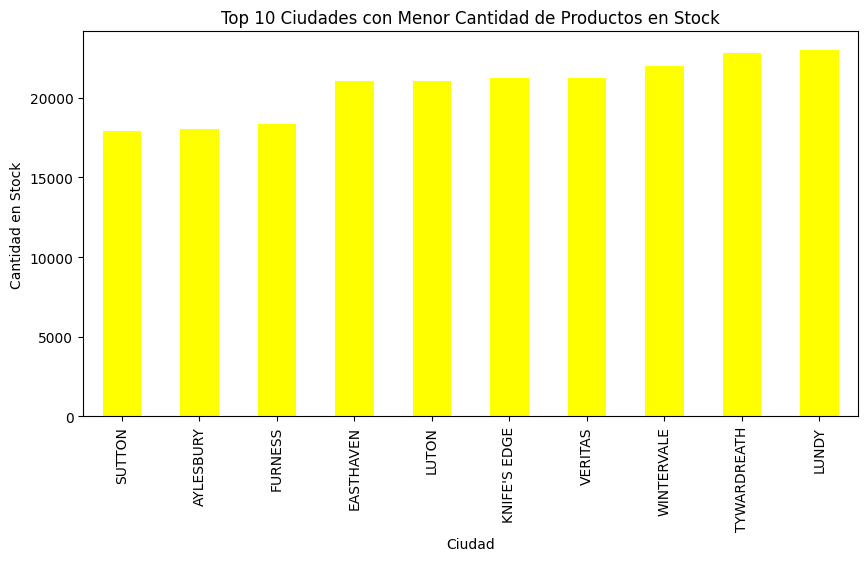

In [15]:
#Graficos para inventario por ciudad
#Sumar productos en stock por ciudad
onhand_city = inv_inicial.groupby('City')['onHand'].sum()

# Top 10 ciudades con mayor cantidad de productos en stock
max_onhand = onhand_city.sort_values(ascending=False).head(10)

# Top 10 ciudades con menor cantidad de productos en stock
min_onhand = onhand_city.sort_values(ascending=True).head(10)

# Gráfico para ciudades con mayor cantidad de productos en stock
plt.figure(figsize=(10, 5))
max_onhand.plot(kind='bar', color='green')
plt.title('Top 10 Ciudades con Mayor Cantidad de Productos en Stock')
plt.xlabel('Ciudad')
plt.ylabel('Cantidad en Stock')
plt.show()

# Gráfico para ciudades con menor cantidad de productos en stock
plt.figure(figsize=(10, 5))
min_onhand.plot(kind='bar', color='yellow')
plt.title('Top 10 Ciudades con Menor Cantidad de Productos en Stock')
plt.xlabel('Ciudad')
plt.ylabel('Cantidad en Stock')
plt.show()


In [19]:
inv_inicial.info()

<class 'pandas.core.frame.DataFrame'>
Index: 202806 entries, 0 to 206528
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InventoryId  202806 non-null  object        
 1   Store        202806 non-null  int64         
 2   City         202806 non-null  object        
 3   Brand        202806 non-null  int64         
 4   Description  202806 non-null  object        
 5   onHand       202806 non-null  int64         
 6   Price        202806 non-null  float64       
 7   startDate    202806 non-null  datetime64[ns]
 8   Size_ml      202806 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(3), object(3)
memory usage: 15.5+ MB


In [20]:
#Renombramos, Guardamos el dataframe en tipo csv y listo para normalizar.
inv_inicial = inv_inicial.rename(columns={
    'InventoryID': 'InventorybID',
    'Store': 'StoreID',
    'City': 'City',
    'Brand': 'BrandID',
    'Description': 'Description',
    'onHand': 'OnHand',
    'Price': 'Price',
    'starDate': 'StarDate',
    'Size_ml': 'SizeMl'
    })
inv_inicial.info()
inv_inicial.to_csv (r"C:\Users\Admin\Desktop\proyecto final\Proceso\CSV listos\InventarioInicial.csv")

<class 'pandas.core.frame.DataFrame'>
Index: 202806 entries, 0 to 206528
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InventoryId  202806 non-null  object        
 1   StoreID      202806 non-null  int64         
 2   City         202806 non-null  object        
 3   BrandID      202806 non-null  int64         
 4   Description  202806 non-null  object        
 5   OnHand       202806 non-null  int64         
 6   Price        202806 non-null  float64       
 7   startDate    202806 non-null  datetime64[ns]
 8   SizeMl       202806 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(3), object(3)
memory usage: 15.5+ MB
